In [32]:
import sys
sys.path.append('..')

from helpers.lift import area_ratio_scorer, area_ratio, plot_lift_chart

import pandas as pd

df = pd.read_csv('../data/engineered.csv')
df.head()

,Unnamed: 0,X1,X3,X5,X6,X7,X8,X9,X10,X11,...,payment_total,payment_avg,payment_std,payment_max,payment_min,payment_growth,payment_trend,payment_zero_count,payment_all_zero,payment_low_count
0,0,20000,2,24,2,2,-1,-1,-2,-2,...,689,114.833336,281.28308,689,0,0,59.057144,5,0,6
1,1,120000,2,26,-1,2,0,0,0,2,...,5000,833.333300,752.77264,2000,0,-2000,-200.000000,2,0,2
2,2,90000,2,34,0,0,0,0,0,0,...,11018,1836.333400,1569.81540,5000,1000,-3482,-454.571440,0,0,0
3,3,50000,2,37,0,0,0,0,0,0,...,8388,1398.000000,478.05817,2019,1000,1000,227.142850,0,0,0
4,4,50000,2,57,-1,0,-1,0,0,0,...,59049,9841.500000,13786.23000,36681,679,1321,3302.314200,0,0,2


In [14]:
from sklearn.model_selection import train_test_split

X = df.drop('Y', axis=1)
y = df['Y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

import numpy as np

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(svd_solver="full")),
    ("lda", LDA())
])

param_grid = [
    # Robust: lsqr + shrinkage (auto or a few values)
    {
        "lda__solver": ["lsqr"],
        "lda__shrinkage": ["auto", 0.1, 0.5, 0.9],
        "lda__tol": [1e-4],
        # avoid priors unless required
    },
    # Optional: svd (ignores shrinkage; can use store_covariance)
    {
        "lda__solver": ["svd"],
        "lda__tol": [1e-4],
        "lda__store_covariance": [False],  # True adds memory with no gain usually
    },
    # If you really want eigen, force strong shrinkage only
    {
        "lda__solver": ["eigen"],
        "lda__shrinkage": [0.5, 0.9, "auto"],
        "lda__tol": [1e-4],
    },
]

gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring=area_ratio_scorer,   # or your area_ratio wrapper via make_scorer
    cv=5,
    n_jobs=-1,
    verbose=1,
    error_score=np.nan   # use 'raise' once for debugging
)
gs.fit(X_train, y_train)
print("Best params:", gs.best_params_)
print("Best CV score:", gs.best_score_)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params: {'lda__shrinkage': 'auto', 'lda__solver': 'eigen', 'lda__tol': 0.0001}
Best CV score: 0.5515549224347636


Best params: {'lda__solver': 'svd', 'lda__store_covariance': False, 'lda__tol': 0.0001}
Best CV score: 0.775228407987964

In [45]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline

optimized_lda_pipeline = Pipeline([
        ("scaler", StandardScaler()),
    ("pca", PCA(svd_solver="full")),
    ('lda', LinearDiscriminantAnalysis(
                                    shrinkage='auto', 
                                    solver='eigen', 
                                    tol=0.0001)
    )
])

optimized_lda_pipeline.fit(X_train, y_train)

,steps,"[('scaler', ...), ('pca', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_components,None
,copy,True
,whiten,False
,svd_solver,'full'


In [46]:
from sklearn.metrics import accuracy_score, classification_report

y_train_pred_optimized = optimized_lda_pipeline.predict(X_train)
y_train_proba_optimized = optimized_lda_pipeline.predict_proba(X_train)[:, 1]

y_test_pred_optimized = optimized_lda_pipeline.predict(X_test)
y_test_proba_optimized = optimized_lda_pipeline.predict_proba(X_test)[:, 1]

train_optimized_error = 1 - accuracy_score(y_train, y_train_pred_optimized)
train_optimized_area = area_ratio(y_train, y_train_proba_optimized)

test_optimized_error = 1 - accuracy_score(y_test, y_test_pred_optimized)
test_optimized_area = area_ratio(y_test, y_test_proba_optimized)

In [47]:
print(f'TRAIN: Error Rate {train_optimized_error:.4f}\n')
print(f'TRAIN: Area Ratio {train_optimized_area:.4f}\n')
print("TRAIN: Classification Report")
print(classification_report(y_train, y_train_pred_optimized, digits=4, zero_division=0))

TRAIN: Error Rate 0.1853

TRAIN: Area Ratio 0.5582

TRAIN: Classification Report
              precision    recall  f1-score   support

           0     0.8390    0.9434    0.8881     16357
           1     0.6415    0.3588    0.4602      4618

    accuracy                         0.8147     20975
   macro avg     0.7403    0.6511    0.6742     20975
weighted avg     0.7955    0.8147    0.7939     20975



In [48]:
print(f'TEST: Error Rate {test_optimized_error:.4f}\n')
print(f'TEST: Area Ratio {test_optimized_area:.4f}\n')
print("TEST: Classification Report")
print(classification_report(y_test, y_test_pred_optimized, digits=4, zero_division=0))

TEST: Error Rate 0.1903

TEST: Area Ratio 0.5260

TEST: Classification Report
              precision    recall  f1-score   support

           0     0.8314    0.9468    0.8854      6978
           1     0.6443    0.3340    0.4399      2012

    accuracy                         0.8097      8990
   macro avg     0.7378    0.6404    0.6626      8990
weighted avg     0.7895    0.8097    0.7857      8990



In [49]:
sorted_idx = np.argsort(-y_test_proba_optimized)
y_true_sorted = y_test.iloc[sorted_idx].reset_index(drop=True)

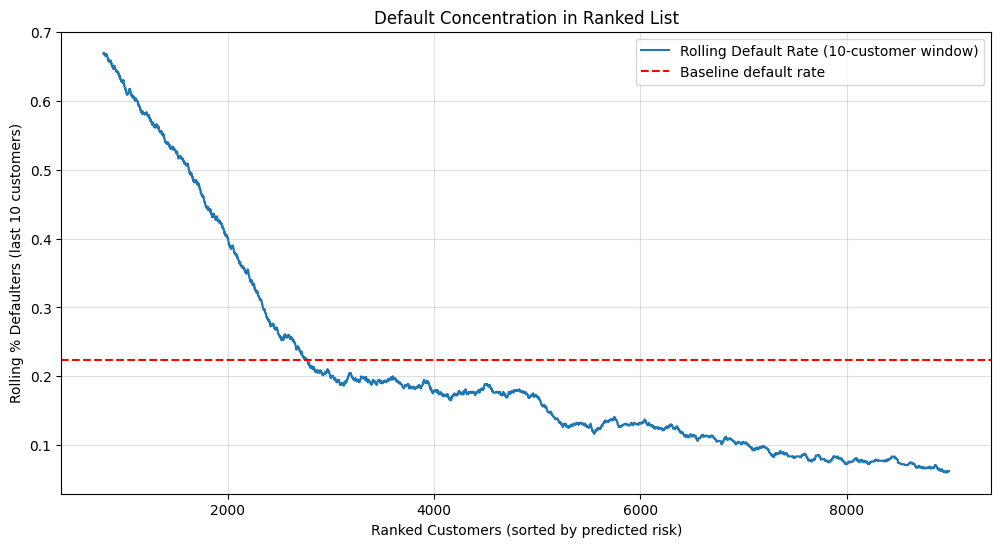

In [50]:
import matplotlib.pyplot as plt

window_size = 800  # rolling over 10 customers
rolling_default_rate = y_true_sorted.rolling(window=window_size).mean()

plt.figure(figsize=(12, 6))

plt.plot(
    rolling_default_rate.values,
    label="Rolling Default Rate (10-customer window)"
)

# Baseline average default rate in test set
plt.axhline(y=y_test.mean(), color="red", linestyle="--", label="Baseline default rate")

plt.xlabel("Ranked Customers (sorted by predicted risk)")
plt.ylabel("Rolling % Defaulters (last 10 customers)")
plt.title("Default Concentration in Ranked List")
plt.legend()
plt.grid(alpha=0.4)
plt.show()


In [51]:
import pandas as pd
import numpy as np

# Total number of customers
n = len(y_true_sorted)

# Total defaults
total_defaults = y_true_sorted.sum()

decile_results = []

# For each decile (10%, 20%, ..., 100%)
for d in range(5, 110, 5):
    cutoff = int((d/100) * n)  # number of customers in top d%
    captured_defaults = y_true_sorted.iloc[:cutoff].sum()
    captured_pct = (captured_defaults / total_defaults) * 100
    decile_results.append({"Top % Population": f"Top {d}%", 
                           "Defaults Captured (%)": round(captured_pct, 2)})

# Create table
decile_df = pd.DataFrame(decile_results)
print(decile_df)


   Top % Population  Defaults Captured (%)
0            Top 5%                  16.00
1           Top 10%                  29.37
2           Top 15%                  41.05
3           Top 20%                  50.00
4           Top 25%                  56.56
5           Top 30%                  61.23
6           Top 35%                  65.21
7           Top 40%                  69.78
8           Top 45%                  73.26
9           Top 50%                  77.83
10          Top 55%                  80.86
11          Top 60%                  83.60
12          Top 65%                  86.83
13          Top 70%                  89.26
14          Top 75%                  91.50
15          Top 80%                  93.69
16          Top 85%                  95.18
17          Top 90%                  97.02
18          Top 95%                  98.56
19         Top 100%                 100.00
20         Top 105%                 100.00


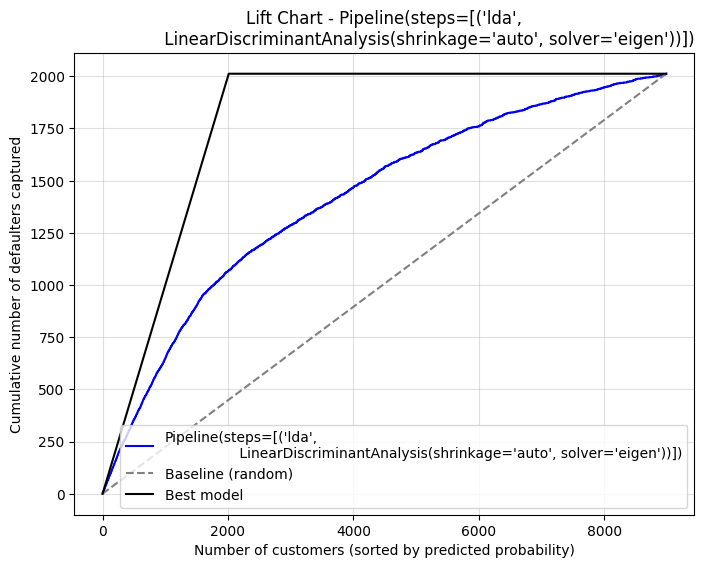

In [44]:
plot_lift_chart(y_test, y_test_proba_optimized, optimized_lda_pipeline)